## Simple Neural Nets with tensorflow

In [1]:
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

%load_ext autoreload
%autoreload
%config Completer.use_jedi=False
%matplotlib inline

In [2]:
tf.executing_eagerly()

True

## Read in data

Using MNIST

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Convert numpy tensors to tensorflow tensors and create batches

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Train with non customizable loop

Non customizable training loop

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time
history = model.fit(train_dataset, epochs=100)

Epoch 1/100
469/469 [==============================] - 2s 5ms/step - loss: 1.9474 - sparse_categorical_accuracy: 0.3760
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 1.8459 - sparse_categorical_accuracy: 0.4386
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 1.7988 - sparse_categorical_accuracy: 0.5273
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 1.6910 - sparse_categorical_accuracy: 0.7346
Epoch 5/100
469/469 [==============================] - 1s 3ms/step - loss: 1.6484 - sparse_categorical_accuracy: 0.7764
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 1.6344 - sparse_categorical_accuracy: 0.7887
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 1.6267 - sparse_categorical_accuracy: 0.7971
Epoch 8/100
469/469 [==============================] - 1s 2ms/step - loss: 1.6215 - sparse_categorical_accuracy: 0.7991
Epoch 9/100
469/469 [===================

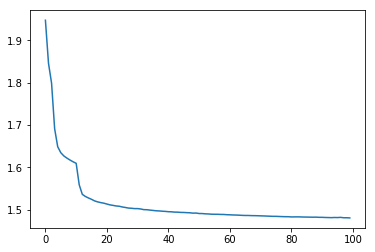

In [16]:
plt.plot(history.history['loss'])

In [17]:
model.evaluate(test_dataset)

79/79 [==============================] - 0s 3ms/step - loss: 1.4975 - sparse_categorical_accuracy: 0.9598


[1.497455608995655, 0.9598]

Customizable training loop

In [21]:
# Define simple neural net
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation="sigmoid")
])

# Define optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Define loss function
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
test_epoch_loss_avg = tf.keras.metrics.Mean()
test_epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [22]:
@tf.function
def train_loop(x, y):

    # Calculate gradients
    with tf.GradientTape() as t:
        # training=training is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(x, training=True)
        loss = loss_func(y, predictions)

    grads = t.gradient(loss, model.trainable_variables)

    # Optimize the model
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Track progress
    epoch_loss_avg(loss)

    # Compare predicted label to actual
    epoch_accuracy.update_state(y, predictions)
    
#     return loss, predictions

In [23]:
%%time
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []
epochs = 100
n_batches = len(list(train_dataset))

for epoch in tqdm(np.arange(epochs)):
    
    for x, y in tqdm(train_dataset, total=n_batches, leave=False):
        train_loop(x, y)

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    # Test
    for (x_valid, y_valid) in test_dataset:
        preds_test = model(x_valid, training=False)
        test_loss = loss_func(y_valid, preds_test)
        test_epoch_loss_avg(test_loss)
        test_epoch_accuracy.update_state(y_valid, preds_test)
    
    test_loss_results.append(test_epoch_loss_avg.result())
    test_accuracy_results.append(test_epoch_accuracy.result())
    
    print(f"Epoch {epoch:03d}: train_loss: {epoch_loss_avg.result():.3f}, "
          f"test_loss: {test_epoch_loss_avg.result():.3f} "
          f"Accuracy: {epoch_accuracy.result():.3f}%"
          f"Test accuracy={test_epoch_accuracy.result():.3f}"
    )
    
    # Clear the current state of the metrics
    epoch_loss_avg.reset_states()
    epoch_accuracy.reset_states()
    test_epoch_loss_avg.reset_states()
    test_epoch_accuracy.reset_states()
    # valid_loss.reset_states(), valid_acc.reset_states()
    
    

Epoch 000: train_loss: 1.768, test_loss: 1.623 Accuracy: 0.600%Test accuracy=0.768


Epoch 001: train_loss: 1.610, test_loss: 1.580 Accuracy: 0.794%Test accuracy=0.845


Epoch 002: train_loss: 1.580, test_loss: 1.563 Accuracy: 0.838%Test accuracy=0.861


Epoch 003: train_loss: 1.565, test_loss: 1.563 Accuracy: 0.861%Test accuracy=0.836


Epoch 004: train_loss: 1.556, test_loss: 1.545 Accuracy: 0.872%Test accuracy=0.894


Epoch 005: train_loss: 1.546, test_loss: 1.541 Accuracy: 0.885%Test accuracy=0.896


Epoch 006: train_loss: 1.541, test_loss: 1.543 Accuracy: 0.889%Test accuracy=0.901


Epoch 007: train_loss: 1.536, test_loss: 1.533 Accuracy: 0.899%Test accuracy=0.903


Epoch 008: train_loss: 1.531, test_loss: 1.529 Accuracy: 0.900%Test accuracy=0.913


Epoch 009: train_loss: 1.528, test_loss: 1.525 Accuracy: 0.902%Test accuracy=0.906


Epoch 010: train_loss: 1.525, test_loss: 1.525 Accuracy: 0.912%Test accuracy=0.916


Epoch 011: train_loss: 1.522, test_loss: 1.522 Accuracy: 0.919%Test accuracy=0.917


Epoch 012: train_loss: 1.520, test_loss: 1.520 Accuracy: 0.916%Test accuracy=0.923


Epoch 013: train_loss: 1.518, test_loss: 1.520 Accuracy: 0.921%Test accuracy=0.918


Epoch 014: train_loss: 1.516, test_loss: 1.519 Accuracy: 0.925%Test accuracy=0.926


Epoch 015: train_loss: 1.514, test_loss: 1.519 Accuracy: 0.927%Test accuracy=0.928


Epoch 016: train_loss: 1.512, test_loss: 1.520 Accuracy: 0.928%Test accuracy=0.913


Epoch 017: train_loss: 1.511, test_loss: 1.517 Accuracy: 0.932%Test accuracy=0.931


Epoch 018: train_loss: 1.511, test_loss: 1.521 Accuracy: 0.934%Test accuracy=0.922


Epoch 019: train_loss: 1.509, test_loss: 1.513 Accuracy: 0.937%Test accuracy=0.931


Epoch 020: train_loss: 1.507, test_loss: 1.512 Accuracy: 0.938%Test accuracy=0.935


Epoch 021: train_loss: 1.507, test_loss: 1.510 Accuracy: 0.939%Test accuracy=0.936


Epoch 022: train_loss: 1.505, test_loss: 1.509 Accuracy: 0.941%Test accuracy=0.934


Epoch 023: train_loss: 1.505, test_loss: 1.509 Accuracy: 0.938%Test accuracy=0.939


Epoch 024: train_loss: 1.503, test_loss: 1.507 Accuracy: 0.942%Test accuracy=0.937


Epoch 025: train_loss: 1.502, test_loss: 1.507 Accuracy: 0.941%Test accuracy=0.938


Epoch 026: train_loss: 1.501, test_loss: 1.507 Accuracy: 0.946%Test accuracy=0.941


Epoch 027: train_loss: 1.501, test_loss: 1.507 Accuracy: 0.948%Test accuracy=0.944


Epoch 028: train_loss: 1.500, test_loss: 1.505 Accuracy: 0.947%Test accuracy=0.941


Epoch 029: train_loss: 1.499, test_loss: 1.508 Accuracy: 0.948%Test accuracy=0.944


Epoch 030: train_loss: 1.498, test_loss: 1.505 Accuracy: 0.951%Test accuracy=0.945


Epoch 031: train_loss: 1.497, test_loss: 1.506 Accuracy: 0.951%Test accuracy=0.946


Epoch 032: train_loss: 1.497, test_loss: 1.503 Accuracy: 0.952%Test accuracy=0.946


Epoch 033: train_loss: 1.497, test_loss: 1.503 Accuracy: 0.952%Test accuracy=0.948


Epoch 034: train_loss: 1.496, test_loss: 1.503 Accuracy: 0.953%Test accuracy=0.947


Epoch 035: train_loss: 1.495, test_loss: 1.505 Accuracy: 0.955%Test accuracy=0.950


Epoch 036: train_loss: 1.495, test_loss: 1.504 Accuracy: 0.954%Test accuracy=0.952


Epoch 037: train_loss: 1.494, test_loss: 1.503 Accuracy: 0.956%Test accuracy=0.949


Epoch 038: train_loss: 1.494, test_loss: 1.500 Accuracy: 0.956%Test accuracy=0.946


Epoch 039: train_loss: 1.493, test_loss: 1.502 Accuracy: 0.956%Test accuracy=0.950


Epoch 040: train_loss: 1.493, test_loss: 1.500 Accuracy: 0.958%Test accuracy=0.953


Epoch 041: train_loss: 1.492, test_loss: 1.501 Accuracy: 0.959%Test accuracy=0.953


Epoch 042: train_loss: 1.492, test_loss: 1.500 Accuracy: 0.959%Test accuracy=0.952


Epoch 043: train_loss: 1.491, test_loss: 1.501 Accuracy: 0.960%Test accuracy=0.952


Epoch 044: train_loss: 1.490, test_loss: 1.500 Accuracy: 0.960%Test accuracy=0.952


Epoch 045: train_loss: 1.491, test_loss: 1.500 Accuracy: 0.958%Test accuracy=0.953


Epoch 046: train_loss: 1.490, test_loss: 1.499 Accuracy: 0.961%Test accuracy=0.954


Epoch 047: train_loss: 1.490, test_loss: 1.499 Accuracy: 0.961%Test accuracy=0.952


Epoch 048: train_loss: 1.489, test_loss: 1.500 Accuracy: 0.963%Test accuracy=0.955


Epoch 049: train_loss: 1.489, test_loss: 1.500 Accuracy: 0.963%Test accuracy=0.956


Epoch 050: train_loss: 1.488, test_loss: 1.499 Accuracy: 0.963%Test accuracy=0.954


Epoch 051: train_loss: 1.488, test_loss: 1.499 Accuracy: 0.962%Test accuracy=0.956


Epoch 052: train_loss: 1.488, test_loss: 1.500 Accuracy: 0.963%Test accuracy=0.953


Epoch 053: train_loss: 1.488, test_loss: 1.499 Accuracy: 0.964%Test accuracy=0.957


Epoch 054: train_loss: 1.487, test_loss: 1.500 Accuracy: 0.965%Test accuracy=0.955


Epoch 055: train_loss: 1.487, test_loss: 1.498 Accuracy: 0.965%Test accuracy=0.956


Epoch 056: train_loss: 1.487, test_loss: 1.499 Accuracy: 0.965%Test accuracy=0.956


Epoch 057: train_loss: 1.487, test_loss: 1.500 Accuracy: 0.965%Test accuracy=0.958


Epoch 058: train_loss: 1.486, test_loss: 1.500 Accuracy: 0.965%Test accuracy=0.957


Epoch 059: train_loss: 1.486, test_loss: 1.500 Accuracy: 0.966%Test accuracy=0.956


Epoch 060: train_loss: 1.486, test_loss: 1.499 Accuracy: 0.965%Test accuracy=0.955


Epoch 061: train_loss: 1.485, test_loss: 1.499 Accuracy: 0.966%Test accuracy=0.958


Epoch 062: train_loss: 1.485, test_loss: 1.499 Accuracy: 0.967%Test accuracy=0.956


Epoch 063: train_loss: 1.485, test_loss: 1.497 Accuracy: 0.968%Test accuracy=0.957


Epoch 064: train_loss: 1.485, test_loss: 1.499 Accuracy: 0.968%Test accuracy=0.957


Epoch 065: train_loss: 1.485, test_loss: 1.499 Accuracy: 0.967%Test accuracy=0.957


Epoch 066: train_loss: 1.484, test_loss: 1.498 Accuracy: 0.968%Test accuracy=0.958


Epoch 067: train_loss: 1.484, test_loss: 1.498 Accuracy: 0.968%Test accuracy=0.958


Epoch 068: train_loss: 1.484, test_loss: 1.498 Accuracy: 0.968%Test accuracy=0.958


Epoch 069: train_loss: 1.484, test_loss: 1.499 Accuracy: 0.967%Test accuracy=0.959


Epoch 070: train_loss: 1.484, test_loss: 1.497 Accuracy: 0.968%Test accuracy=0.958


Epoch 071: train_loss: 1.484, test_loss: 1.499 Accuracy: 0.969%Test accuracy=0.958


Epoch 072: train_loss: 1.483, test_loss: 1.500 Accuracy: 0.970%Test accuracy=0.959


Epoch 073: train_loss: 1.483, test_loss: 1.499 Accuracy: 0.969%Test accuracy=0.959


Epoch 074: train_loss: 1.483, test_loss: 1.499 Accuracy: 0.970%Test accuracy=0.959


Epoch 075: train_loss: 1.483, test_loss: 1.501 Accuracy: 0.970%Test accuracy=0.960


Epoch 076: train_loss: 1.483, test_loss: 1.498 Accuracy: 0.970%Test accuracy=0.959


Epoch 077: train_loss: 1.483, test_loss: 1.498 Accuracy: 0.970%Test accuracy=0.958


Epoch 078: train_loss: 1.482, test_loss: 1.499 Accuracy: 0.971%Test accuracy=0.956


Epoch 079: train_loss: 1.482, test_loss: 1.499 Accuracy: 0.971%Test accuracy=0.959


Epoch 080: train_loss: 1.482, test_loss: 1.499 Accuracy: 0.971%Test accuracy=0.959


Epoch 081: train_loss: 1.482, test_loss: 1.498 Accuracy: 0.971%Test accuracy=0.960


Epoch 082: train_loss: 1.482, test_loss: 1.500 Accuracy: 0.971%Test accuracy=0.957


Epoch 083: train_loss: 1.482, test_loss: 1.498 Accuracy: 0.971%Test accuracy=0.960


Epoch 084: train_loss: 1.482, test_loss: 1.499 Accuracy: 0.972%Test accuracy=0.959


Epoch 085: train_loss: 1.482, test_loss: 1.498 Accuracy: 0.972%Test accuracy=0.959


Epoch 086: train_loss: 1.482, test_loss: 1.499 Accuracy: 0.972%Test accuracy=0.960


Epoch 087: train_loss: 1.481, test_loss: 1.499 Accuracy: 0.972%Test accuracy=0.960


Epoch 088: train_loss: 1.481, test_loss: 1.498 Accuracy: 0.972%Test accuracy=0.960


Epoch 089: train_loss: 1.481, test_loss: 1.498 Accuracy: 0.972%Test accuracy=0.961


Epoch 090: train_loss: 1.481, test_loss: 1.499 Accuracy: 0.972%Test accuracy=0.960


Epoch 091: train_loss: 1.481, test_loss: 1.498 Accuracy: 0.973%Test accuracy=0.959


Epoch 092: train_loss: 1.481, test_loss: 1.498 Accuracy: 0.973%Test accuracy=0.960


Epoch 093: train_loss: 1.481, test_loss: 1.499 Accuracy: 0.973%Test accuracy=0.960


Epoch 094: train_loss: 1.481, test_loss: 1.499 Accuracy: 0.973%Test accuracy=0.960


Epoch 095: train_loss: 1.481, test_loss: 1.499 Accuracy: 0.973%Test accuracy=0.960


Epoch 096: train_loss: 1.480, test_loss: 1.498 Accuracy: 0.973%Test accuracy=0.960


Epoch 097: train_loss: 1.480, test_loss: 1.499 Accuracy: 0.973%Test accuracy=0.961


Epoch 098: train_loss: 1.480, test_loss: 1.498 Accuracy: 0.973%Test accuracy=0.960


Epoch 099: train_loss: 1.480, test_loss: 1.499 Accuracy: 0.974%Test accuracy=0.960

CPU times: user 4min 13s, sys: 2min 43s, total: 6min 57s
Wall time: 2min 11s


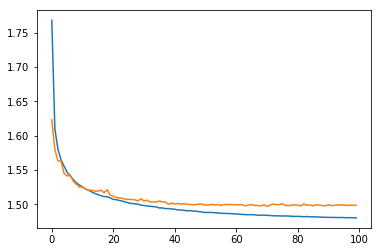

In [26]:
plt.plot(train_loss_results, label="train")
plt.plot(test_loss_results, label="test")

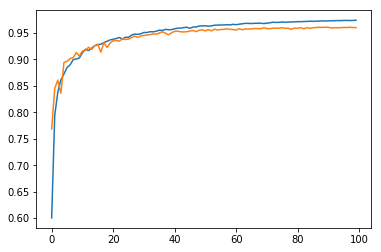

In [27]:
plt.plot(train_accuracy_results, label="train")
plt.plot(test_accuracy_results, label="test")